## Mistral test before create the app.py 


In [28]:
import requests
import pandas as pd

BASE_URL = "https://api.openf1.org/v1"

# Function to search for a Grand Prix by country or name
def get_gp_info(query):
    # Example: endpoint sessions has meeting_name, country_name, circuit_name
    url = f"{BASE_URL}/sessions"
    params = {"country_name": query}  # you can also try 'country_name'
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        return {"error": "Failed to fetch data"}
    
    data = response.json()
    if not data:
        return {"message": f"No GP found for query: {query}"}
    
    # Put into DataFrame for easier handling
    df = pd.DataFrame(data)
    # Just keep unique meeting, country, circuit
    #result = df[["meeting_name", "country_name", "circuit_short_name"]].drop_duplicates()
    
    return df

# Example usage
print(get_gp_info("Singapore gp"))



{'message': 'No GP found for query: Singapore gp'}


In [ ]:
# import os
# from mistralai import Mistral
# import re


# api_key = "qihykHg51EDcgFERlOk1OLfAEiFJwp6K"
# model = "mistral-small"

# client = Mistral(api_key=api_key)

# SESSION_SYNONYMS = {
#         "Race":       [r"\brace\b", r"\bgp\b", r"grand\s*prix", r"\bcourse\b"],
#         "Qualifying": [r"\bqualifying\b", r"\bquali\b", r"\bq\b", r"\bqualifaction\b"],
#         "Sprint":     [r"\bsprint\b"],
#         "FP1":        [r"\bfp1\b", r"practice\s*1", r"free\s*practice\s*1", r"\bp1\b"],
#         "FP2":        [r"\bfp2\b", r"practice\s*2", r"free\s*practice\s*2", r"\bp2\b"],
#         "FP3":        [r"\bfp3\b", r"practice\s*3", r"free\s*practice\s*3", r"\bp3\b"],
#     }
# def compose_answer(question: str, context_str: str) -> str:
#     """Let Mistral answer with the retrieved context appended."""
#     messages = [
#         {
#             "role": "system",
#             "content": (
#                 "You are an F1 assistant. Use the provided context exactly and avoid fabrications. "
#                 "Cite drivers/teams and numbers only if present in the context."
#             ),
#         },
#         {"role": "user", "content": f"Question: {question}\n\nContext:\n{context_str}"}
#     ]
#     resp = client.chat.complete(model=model, messages=messages)
#     return resp.choices[0].message.content


# def extract_year(q: str, default_year: int) -> int:
#     m = re.search(r"\b(20\d{2})\b", q or "")
#     return int(m.group(1)) if m else int(default_year)

# def extract_session_hint(q: str) -> str | None:
#     ql = (q or "").lower()
#     for canon, pats in SESSION_SYNONYMS.items():
#         if any(re.search(p, ql) for p in pats):
#             return canon
#     return None
    
# def extract_gp_hint(q: str) -> str | None:
#     return None

# def strip_session_words(q: str) -> str:
#     q2 = (q or "")
#     for pats in SESSION_SYNONYMS.values():
#         for p in pats:
#             q2 = re.sub(p, " ", q2, flags=re.I)
#     q2 = re.sub(r"\b(grand|prix|race|gp|qualifying|quali|sprint|practice|free)\b", " ", q2, flags=re.I)
#     q2 = re.sub(r"[^A-Za-z0-9\s\-]", " ", q2)
#     q2 = re.sub(r"\s+", " ", q2).strip()
#     return q2

# question="Hi, Who is the driver who wins the gp of canada in 2022?"

# year = extract_year(question, 2020)
# session = extract_session_hint(question)
# jsp=extract_gp_hint(question)
# print(jsp)
# print(session)
# print(year)
# compose_answer(question, f"Year: {2022}")


None
Race
2022


'At the time of this conversation, the 2022 Canadian Grand Prix has not yet occurred, therefore I cannot provide you with the winning driver. I would be happy to help you with any F1-related questions once the race has taken place.'

#### Fonction to get info about a query and set the workflow for the agent

In [ ]:
# agent_f1.py
import re
import os
import requests
import pandas as pd

OPENF1 = "https://api.openf1.org/v1"

def _extract_year(text: str, default=None):
    m = re.search(r"\b(20\d{2})\b", text)
    return int(m.group(1)) if m else default

def _fetch(endpoint: str, **params):
    r = requests.get(f"{OPENF1}/{endpoint}", params=params, timeout=10)
    r.raise_for_status()
    return r.json()

def find_race_session(query: str): 
    """
    À partir d'un texte libre ('résumé grand prix de singapore 2025'),
    on détecte l'année + on retrouve la session de course correspondante (session_type='Race').
    Retourne un dict avec session_key, meeting_name, country_name, location, circuit_short_name, year.
    """
    year = _extract_year(query)  # None si absent -> on cherchera sans filtrer
    # On récupère toutes les sessions (évent. avec filtre d'année), puis on matche sur plusieurs colonnes
    sess_params = {"year": year} if year else {}
    sessions = pd.DataFrame(_fetch("sessions", **sess_params))
    if sessions.empty:
        raise ValueError("Aucune session trouvée sur OpenF1 (vérifie la connexion ou l'année).")

    # On ne garde que les 'Race'
    if "session_type" in sessions.columns:
        sessions = sessions[sessions["session_type"].str.lower() == "race"]
   
    # Colonnes utiles pour le matching
    cols = ["meeting_name", "country_name", "location", "circuit_short_name"]
    for c in cols:
        if c not in sessions.columns:
            sessions[c] = ""

    # Normalisation de la requête (ex: 'grand prix de singapore 2025' -> 'singapore')
    q = query.lower()
    tokens = [t for t in re.split(r"[^a-z0-9]+", q) if t]
    # on privilégie un match large: si au moins un token matche une colonne
    mask = False
    for c in cols:
        mask = mask | sessions[c].fillna("").str.lower().apply(
            lambda x: any(tok in x for tok in tokens)
        )

    cand = sessions[mask] if mask is not False and mask.any() else sessions

    # S'il y a plusieurs éditions (même meeting sur plusieurs années), on privilégie l'année extraite
    if year is not None and "year" in cand.columns:
        cand = cand[cand["year"] == year] or cand

    # Ordre de préférence : plus récent puis premier
    cand = cand.sort_values(["year", "date_start"], ascending=[False, True])
    if cand.empty:
        raise ValueError(f"Impossible de trouver une course correspondant à: '{query}'")

    row = cand.iloc[0].to_dict()
    return {
        "session_key": int(row["session_key"]),
        "meeting_key": int(row["meeting_key"]),
        "meeting_name": row.get("meeting_name") or "",
        "country_name": row.get("country_name") or "",
        "location": row.get("location") or "",
        "circuit_short_name": row.get("circuit_short_name") or "",
        "year": int(row.get("year")) if not pd.isna(row.get("year")) else None,
    }


### Fontion to obtain info **about** a gp

In [ ]:

def get_classification(session_key: int) -> pd.DataFrame:
    """Classement officiel de la course via /session_result + noms/équipes via /drivers."""
    res = pd.DataFrame(_fetch("session_result", session_key=session_key))
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))

    if not res.empty and not drv.empty:
        res = res.merge(
            drv[["driver_number", "full_name", "name_acronym", "team_name"]],
            on="driver_number", how="left"
        )
        res = res.sort_values("position")
    return res

def get_grid_p1_driver(session_key: int) -> dict | None:
    """Pole (grid P1 réel) via /starting_grid."""
    meeting = pd.DataFrame(_fetch("sessions", session_key=session_key)).iloc[0]["meeting_key"]
    grid = pd.DataFrame(_fetch("starting_grid", meeting_key=meeting))
    if grid.empty:
        return None
    # On récupère le nom
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))
    g = grid.iloc[0].to_dict()
    name = None
    team = None
    if not drv.empty:
        row = drv[drv["driver_number"] == g["driver_number"]].iloc[0]
        name = row.get("full_name")
        team = row.get("team_name")
    return {"driver_number": g["driver_number"], "name": name, "team": team}

def get_fastest_lap(session_key: int) -> dict | None:
    """Meilleur tour en course via /laps (min lap_duration)."""
    laps = pd.DataFrame(_fetch("laps", session_key=session_key))
    if laps.empty or "lap_duration" not in laps.columns:
        return None
    # On ignore les tours avec durée manquante
    laps = laps.dropna(subset=["lap_duration"])
    idx = laps["lap_duration"].astype(float).idxmin()
    best = laps.loc[idx]
    # Map to driver name
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))
    name = None
    team = None
    if not drv.empty:
        r = drv[drv["driver_number"] == int(best["driver_number"])].iloc[0]
        name = r.get("full_name")
        team = r.get("team_name")
    return {
        "driver_number": int(best["driver_number"]),
        "name": name,
        "team": team,
        "lap_number": int(best["lap_number"]),
        "lap_time_s": float(best["lap_duration"]),
    }

def get_retirements(session_key: int) -> pd.DataFrame:
    """Liste des abandons via le flag dnf de /session_result."""
    res = pd.DataFrame(_fetch("session_result", session_key=session_key))
    if res.empty:
        return res
    dnfs = res[res["dnf"] == True].copy()
    if dnfs.empty:
        return dnfs
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))
    if not drv.empty:
        dnfs = dnfs.merge(
            drv[["driver_number", "full_name", "team_name"]],
            on="driver_number", how="left"
        )
        #if dns then retirement_reason = dns, if dnf then retirement_reason = dnf, if dnq then retirement_reason = dnq
        dnfs["retirement_reason"] = dnfs.apply(
            lambda row: "DNS" if row.get("dns") else ("DNF" if row.get("dnf") else ("DNQ" if row.get("dnq") else "Unknown")),
            axis=1
        )
    return dnfs[["position", "driver_number", "full_name", "team_name", "number_of_laps", "retirement_reason"]].sort_values(
        by=["position", "number_of_laps"], ascending=[True, False]
    )

def build_gp_summary(query: str) -> dict:
    """Pipeline complet: retrouve la course + assemble les infos clés."""
    meta = find_race_session(query)
    session_key = meta["session_key"]

    table = get_classification(session_key)
    top3 = table.head(3)[["position", "full_name", "team_name"]].to_dict(orient="records") if not table.empty else []

    grid_p1 = get_grid_p1_driver(session_key)
    fast = get_fastest_lap(session_key)
    dnfs = get_retirements(session_key)

    summary = {
        "meta": meta,
        "top3": top3,
        "grid_p1": grid_p1,
        "fastest_lap": fast,
        "dnf_count": int(dnfs.shape[0]) if not dnfs.empty else 0,
        "dnf_list": dnfs.to_dict(orient="records") if not dnfs.empty else [],
        "raw_table": table,  # DataFrame complet si tu veux l'afficher
    }
    return summary


In [1]:
# Cell 1: imports
import re
import os
import math
import time
from functools import lru_cache

import requests
import pandas as pd


In [8]:
# Cell 2: basic HTTP helper with small retry
OPENF1 = "https://api.openf1.org/v1"

def _fetch(endpoint: str, **params):
    r = requests.get(f"{OPENF1}/{endpoint}", params=params, timeout=10)
    r.raise_for_status()
    return r.json()

def _get(endpoint: str, **params):
    """Small GET helper with retries."""
    url = f"{OPENF1}/{endpoint}"
    for attempt in range(3):
        try:
            r = requests.get(url, params=params, timeout=15)
            r.raise_for_status()
            return r.json()
        except Exception as e:
            if attempt == 2:
                raise
            time.sleep(0.7 * (attempt + 1))

def _extract_year(text: str, default=None):
    m = re.search(r"\b(20\d{2})\b", text)
    return int(m.group(1)) if m else default

# Common aliases (expand as you wish)
ALIASES = {
    "monza": "Italian",
    "imola": "Emilia Romagna",
    "zandvoort": "Dutch",
    "sakhir": "Bahrain",
    "marina": "Singapore",
    "yas": "Abu Dhabi",
    "americas": "United States",
    "austin": "United States",
    "miami": "Miami",
    "vegas": "Las Vegas",
    "baku": "Azerbaijan",
    "catalunya": "Spanish",
    "barcelona": "Spanish",
    "hungaroring": "Hungarian",
    "brasilia": "Brazil"
}

def _normalize_query(q: str) -> str:
    q = q.lower().strip()
    for k, v in ALIASES.items():
        if k in q:
            q += f" {v.lower()}"
    return q


In [9]:
import re
import pandas as pd
import requests

OPENF1 = "https://api.openf1.org/v1"

def _get(endpoint: str, **params):
    r = requests.get(f"{OPENF1}/{endpoint}", params=params, timeout=15)
    r.raise_for_status()
    return r.json()

STOPWORDS = {
    "grand","prix","gp","g","de","du","des","le","la","les","the",
    "race","résumé","resume","summary","round","of","formula","f1"
}

# Aliases → canoniques (à étendre au besoin)
ALIASES_COUNTRY = {
    "singapore":"singapore",
    "italy":"italy","italie":"italy",
    "emilia":"italy","imola":"italy",
    "netherlands":"netherlands","dutch":"netherlands","zandvoort":"netherlands",
    "bahrain":"bahrain","sakhir":"bahrain",
    "spain":"spain","espagne":"spain","barcelona":"spain","catalunya":"spain",
    "usa":"united states","austin":"united states","americas":"united states",
    "miami":"miami","vegas":"las vegas","las":"las vegas",
    "japan":"japan","suzuka":"japan",
    "saudi":"saudi arabia","jeddah":"saudi arabia",
    "uae":"abu dhabi","yas":"abu dhabi",
    "monaco":"monaco",
    "australia":"australia","melbourne":"australia",
    "canada":"canada","montreal":"canada",
    "mexico":"mexico","cdmx":"mexico",
    "qatar":"qatar","losail":"qatar",
    "austria":"austria","spielberg":"austria","red":"austria",
    "hungary":"hungary","budapest":"hungary",
    "belgium":"belgium","spa":"belgium",
    "uk":"great britain","britain":"great britain","silverstone":"great britain",
    "azerbaijan":"azerbaijan","baku":"azerbaijan",
    "brasilia": "brazil", "brazil": "brazil", "brésil": "brazil"
}

ALIASES_MEETING = {
    "monza":"italian",
    "imola":"emilia romagna",
    "zandvoort":"dutch",
    "sakhir":"bahrain",
    "miami":"miami",
    "vegas":"las vegas","las vegas":"las vegas",
    "barcelona":"spanish","catalunya":"spanish",
    "jeddah":"saudi arabian",
    "suzuka":"japanese",
    "silverstone":"british",
    "spa":"belgian",
    "budapest":"hungarian",
    "spielberg":"austrian",
    "singapore":"singapore",
    "interlagos":"brazil"
}

def _extract_year(text: str, default=None):
    m = re.search(r"\b(20\d{2})\b", text)
    return int(m.group(1)) if m else default

def _clean_tokens(q: str):
    toks = [t for t in re.split(r"[^a-z0-9]+", q.lower()) if t]
    return [t for t in toks if t not in STOPWORDS and not t.isdigit()]

def _hints(tokens):
    country = set()
    meeting = set()
    city_or_circuit = set()
    for t in tokens:
        if t in ALIASES_COUNTRY: country.add(ALIASES_COUNTRY[t])
        if t in ALIASES_MEETING: meeting.add(ALIASES_MEETING[t])
        # brut: tout token non mappé est potentiellement une ville/circuit
        if t not in ALIASES_COUNTRY and t not in ALIASES_MEETING:
            city_or_circuit.add(t)
    return country, meeting, city_or_circuit

def find_session_from_query(query: str, prefer="race"):
    """
    Trouve la bonne session à partir d'une requête libre.
    - retire des stopwords (grand/prix/de/…)
    - fabrique des 'hints' pays/meeting/ville-circuit
    - score chaque session plutôt que de faire un simple contains()
    """
    q = query.strip().lower()
    year = _extract_year(q)
    tokens = _clean_tokens(q)
    want_sprint = "sprint" in q
    target_type = "Sprint" if want_sprint else "Race"

    # Hints
    hint_country, hint_meeting, hint_citycirc = _hints(tokens)

    # Fetch sessions (filtre année si présent)
    params = {"year": year} if year else {}
    df = pd.DataFrame(_get("sessions", **params))
    if df.empty:
        raise ValueError("No sessions from OpenF1 for given filters.")

    # Filtrer par type
    if "session_type" in df.columns:
        df = df[df["session_type"].str.lower() == target_type.lower()]
    else:
        df = df[df["session_name"].str.contains(target_type, case=False, na=False)]
    if df.empty:
        raise ValueError(f"No {target_type} sessions found.")

    # Colonnes utiles
    for c in ["meeting_name","country_name","location","circuit_short_name","year","date_start"]:
        if c not in df.columns:
            df[c] = ""

    # Pré-score via hints forts (country/meeting) si présents
    def score_row(row):
        s = 0
        meeting = str(row["meeting_name"]).lower()
        country = str(row["country_name"]).lower()
        location = str(row["location"]).lower()
        circuit  = str(row["circuit_short_name"]).lower()

        # Hints pays -> gros bonus
        for hc in hint_country:
            if hc and hc in country: s += 30

        # Hints meeting (Italian, Bahrain, etc.)
        for hm in hint_meeting:
            if hm and hm in meeting: s += 20

        # Ville/circuit tokens
        for t in hint_citycirc:
            if t in location: s += 12
            if t in circuit:  s += 10
            if t in meeting:  s += 8
            if t in country:  s += 6

        # Tokens restants (faible poids) — évite que "grand/prix" pollue
        for t in tokens:
            if t in {"sprint"}:  # déjà pris en compte
                continue
            if t in meeting:  s += 2
            if t in country:  s += 2
            if t in location: s += 2
            if t in circuit:  s += 2

        # Bonus si année exacte
        try:
            if year and int(row.get("year", 0)) == year:
                s += 5
        except Exception:
            pass

        return s

    df = df.copy()
    df["__score__"] = df.apply(score_row, axis=1)

    # Si on a un hint pays fort, on peut éliminer le reste (hard filter)
    if hint_country:
        mask_country = False
        for hc in hint_country:
            mask_country = mask_country | df["country_name"].str.lower().str.contains(hc, na=False)
        if mask_country.any():
            df = df[mask_country]

    # Tri: score desc, puis année desc, puis date_start asc
    if "year" in df.columns and "date_start" in df.columns:
        df = df.sort_values(["__score__", "year", "date_start"], ascending=[False, False, True])
    else:
        df = df.sort_values("__score__", ascending=False)

    if df.empty or df.iloc[0]["__score__"] <= 0:
        # dernier recours: filter strict sur 'singapore' etc.
        for t in list(hint_country) + list(hint_meeting) + list(hint_citycirc):
            strict = df[
                df["meeting_name"].str.lower().str.contains(t, na=False) |
                df["country_name"].str.lower().str.contains(t, na=False) |
                df["location"].str.lower().str.contains(t, na=False) |
                df["circuit_short_name"].str.lower().str.contains(t, na=False)
            ]
            if not strict.empty:
                df = strict
                break

    if df.empty:
        raise ValueError(f"No matching {target_type} found for query: '{query}'")

    row = df.iloc[0].to_dict()
    return {
        "session_key": int(row["session_key"]),
        "meeting_key": int(row["meeting_key"]),
        "meeting_name": row.get("meeting_name") or "",
        "country_name": row.get("country_name") or "",
        "location": row.get("location") or "",
        "circuit_short_name": row.get("circuit_short_name") or "",
        "year": int(row.get("year")) if pd.notna(row.get("year")) else None,
        "session_type": target_type,
        "debug_top_hits": df.head(5)[
            ["__score__","year","meeting_name","country_name","location","circuit_short_name","session_key"]
        ].to_dict(orient="records"),  # utile pour debugger
    }


In [10]:
# Cell 4: data fetchers
def get_classification(session_key: int) -> pd.DataFrame:
    res = pd.DataFrame(_get("session_result", session_key=session_key))
    drv = pd.DataFrame(_get("drivers", session_key=session_key))
    if not res.empty and not drv.empty:
        res = res.merge(
            drv[["driver_number", "full_name", "name_acronym", "team_name"]],
            on="driver_number", how="left"
        )
        res = res.sort_values("position")
    return res

def get_grid_p1(session_key: int):
    """Pole (grid P1 réel) via /starting_grid."""
    meeting = pd.DataFrame(_fetch("sessions", session_key=session_key)).iloc[0]["meeting_key"]
    grid = pd.DataFrame(_fetch("starting_grid", meeting_key=meeting))
    if grid.empty:
        return None
    # On récupère le nom
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))
    g = grid.iloc[0].to_dict()
    name = None
    team = None
    if not drv.empty:
        row = drv[drv["driver_number"] == g["driver_number"]].iloc[0]
        name = row.get("full_name")
        team = row.get("team_name")
    return {"driver_number": g["driver_number"], "name": name, "team": team}


def get_fastest_lap(session_key: int):
    laps = pd.DataFrame(_get("laps", session_key=session_key))
    if laps.empty or "lap_duration" not in laps.columns:
        return None
    laps = laps.dropna(subset=["lap_duration"])
    laps["lap_duration"] = laps["lap_duration"].astype(float)
    idx = laps["lap_duration"].idxmin()
    best = laps.loc[idx]
    drv = pd.DataFrame(_get("drivers", session_key=session_key))
    name = team = None
    if not drv.empty:
        r = drv[drv["driver_number"] == int(best["driver_number"])]
        if not r.empty:
            rr = r.iloc[0]
            name, team = rr.get("full_name"), rr.get("team_name")
    return {
        "driver_number": int(best["driver_number"]),
        "name": name,
        "team": team,
        "lap_number": int(best["lap_number"]),
        "lap_time_s": float(best["lap_duration"]),
    }

def get_dnfs(session_key: int) -> pd.DataFrame:
    """Liste des abandons via le flag dnf de /session_result."""
    res = pd.DataFrame(_fetch("session_result", session_key=session_key))
    if res.empty:
        return res
    dnfs = res[res["dnf"] == True].copy()
    if dnfs.empty:
        return dnfs
    drv = pd.DataFrame(_fetch("drivers", session_key=session_key))
    if not drv.empty:
        dnfs = dnfs.merge(
            drv[["driver_number", "full_name", "team_name"]],
            on="driver_number", how="left"
        )
        #if dns then retirement_reason = dns, if dnf then retirement_reason = dnf, if dnq then retirement_reason = dnq
        dnfs["retirement_reason"] = dnfs.apply(
            lambda row: "DNS" if row.get("dns") else ("DNF" if row.get("dnf") else ("DNQ" if row.get("dnq") else "Unknown")),
            axis=1
        )
    return dnfs[["position", "driver_number", "full_name", "team_name", "number_of_laps", "retirement_reason"]].sort_values(
        by=["position", "number_of_laps"], ascending=[True, False]
    )

In [11]:
# Cell 5: assemble + plain-text summarizer
def build_gp_summary(query: str) -> dict:
    meta = find_session_from_query(query)
    k = meta["session_key"]

    table = get_classification(k)
    top3 = table.head(3)[["position","full_name","team_name"]].to_dict(orient="records") if not table.empty else []

    grid_p1 = get_grid_p1(k)
    fl = get_fastest_lap(k)
    dnfs = get_dnfs(k)

    return {
        "meta": meta,
        "top3": top3,
        "grid_p1": grid_p1,
        "fastest_lap": fl,
        "dnf_count": int(dnfs.shape[0]) if not dnfs.empty else 0,
        "dnf_list": dnfs.to_dict(orient="records") if not dnfs.empty else [],
        "classification": table,  # full dataframe
    }

def summarize_plain(summary: dict) -> str:
    m = summary["meta"]
    lines = []
    lines.append(f"{m.get('meeting_name','')} {m.get('year','')}")
    lines.append(f"{m.get('country_name','')} • {m.get('location','')} • {m.get('circuit_short_name','')} • {m.get('session_type','')}")
    if summary["top3"]:
        podium = " / ".join([f"P{r['position']} {r['full_name']} ({r['team_name']})" for r in summary["top3"]])
        lines.append(f"Podium: {podium}")
    if summary["grid_p1"]:
        lines.append(f"Grid P1: {summary['grid_p1']['name']} ({summary['grid_p1']['team']})")
    if summary["fastest_lap"]:
        fl = summary["fastest_lap"]
        lines.append(f"Fastest lap: {fl['name']} ({fl['team']}) (lap {fl['lap_number']}, {fl['lap_time_s']:.3f}s)")
    if summary["dnf_count"]:
        names = ", ".join([d.get("full_name","") for d in summary["dnf_list"]])
        lines.append(f"DNFs ({summary['dnf_count']}): {names}")
    if summary["classification"] is not None and not summary["classification"].empty:
        lines.append("Full classification of the drivers:")
        df = summary["classification"][["position","full_name"]]
        #transform df in one row 1 :  name, 2 : name, ...
        #if nan put 20 places
        df = df.fillna(20)
        classif = " | ".join([f"{int(r['position'])}: {r['full_name']}" for _, r in df.iterrows()])
        lines.append(classif)

    return "\n".join(lines)


In [33]:
# Cell 6: optional Mistral summarizer
def summarize_with_mistral(summary: dict, model: str = "mistral-small", query: str = ""):
    api_key = 'qihykHg51EDcgFERlOk1OLfAEiFJwp6K'
    if not api_key:
        # no key -> fallback to plain text
        return summarize_plain(summary)

    try:
        from mistralai import Mistral
    except Exception:
        return summarize_plain(summary)

    m = summary["meta"]
    facts = summarize_plain(summary)

    prompt = f"""
    You are a concise Formula 1 analyst. Answer to the following question: {query}.
    Write a short summary of the event (5-8 sentences). USE ONLY the facts below.
    Do not speculate. End with one sentence about the circuit/context.

    Facts:
    {facts}
    """ 
    client = Mistral(api_key=api_key)
    resp = client.chat.complete(
        model=model,
        messages=[{"role":"user", "content": prompt}],
        temperature=0.2,
        max_tokens=400
    )
    # Mistral SDK variants may expose message differently:
    return resp.choices[0].message.content



In [30]:
# Cell 7: try a query
q = "What is the drivers who did the worst race?"
q2="What is the drivers who finish last in the race in Canada 2025?"
summary = build_gp_summary(q2)
# print(summarize_plain(summary))


In [38]:
print(summarize_with_mistral(summary, query=q2,model= "mistral-medium"))

The last-placed finisher in the **2025 Canadian Grand Prix** was **Lance Stroll** (17th), with **Lando Norris, Liam Lawson, and Alexander Albon** retiring (DNF).

George Russell dominated the race, securing pole, victory, and fastest lap (1:14.119 on lap 63) for Mercedes. Max Verstappen (Red Bull) and rookie Kimi Antonelli (Mercedes) completed the podium. The race saw 18 classified finishers, with Oliver Bearman (11th) and Franco Colapinto (13th) among the notable midfield runners. Three drivers failed to finish, including Norris (lap 18), Lawson (lap 30), and Albon (lap 45).

The **Circuit Gilles Villeneuve**, known for its tight walls and high-speed chicanes, delivered a mix of strategy and overtaking in Montreal.


In [40]:
print(summarize_with_mistral(summary, query=q))


In the 2


In [42]:
from __future__ import annotations
import json, time, random
from pathlib import Path
from typing import Dict, Any, Optional
import requests

BASE = "https://api.jolpi.ca/ergast/f1"
RAW = Path("data/raw/jolpi")
RAW.mkdir(parents=True, exist_ok=True)

sess = requests.Session()
sess.headers.update({"User-Agent": "f1-season-analytics/1.0"})

def save_json(path: Path, data: Dict[str, Any]) -> None:
    path.write_text(json.dumps(data, ensure_ascii=False), encoding="utf-8")

def load_json(path: Path) -> Dict[str, Any]:
    return json.loads(path.read_text(encoding="utf-8"))

def cache_path(name: str) -> Path:
    safe = name.strip('/').replace('/', '_').replace('?', '_').replace('&', '_').replace('=', '_')
    return RAW / f"{safe}.json"

def get_paged(endpoint: str, params: Optional[Dict[str, Any]] = None,
              limit: int = 500, sleep: float = 0.5,
              max_retries: int = 6, backoff_base: float = 1.8,
              use_cache: bool = True) -> Dict[str, Any]:
    """
    Jolpi/Ergast pagination with rate-limit handling (429) and retries.
    Returns merged MRData with concatenated table rows and caches to disk.
    """
    params = dict(params or {})
    params["limit"] = limit

    cpath = cache_path(f"{endpoint}?limit={limit}")
    if use_cache and cpath.exists():
        try:
            return load_json(cpath)
        except Exception:
            pass

    def _request_with_retry(offset: int) -> Dict[str, Any]:
        for attempt in range(max_retries):
            try:
                r = sess.get(f"{BASE}{endpoint}", params={**params, "offset": offset}, timeout=30)
                if r.status_code == 429:
                    ra = r.headers.get("Retry-After")
                    wait_s = float(ra) if ra and ra.isdigit() else backoff_base ** attempt
                    wait_s += random.uniform(0, 0.5)
                    time.sleep(wait_s)
                    continue
                if 500 <= r.status_code < 600:
                    wait_s = backoff_base ** attempt + random.uniform(0, 0.5)
                    time.sleep(wait_s)
                    continue
                r.raise_for_status()
                return r.json()
            except requests.RequestException:
                wait_s = backoff_base ** attempt + random.uniform(0, 0.5)
                time.sleep(wait_s)
                continue
        r = sess.get(f"{BASE}{endpoint}", params={**params, "offset": offset}, timeout=30)
        r.raise_for_status()
        return r.json()

    data = _request_with_retry(0)
    mr = data.get("MRData", {})
    table_key = next((k for k in ("RaceTable","StandingsTable","CircuitTable","DriverTable",
                                  "ConstructorTable","StatusTable","LapTable") if k in mr), None)
    if not table_key:
        save_json(cpath, data)
        return data
    tbl = mr[table_key]
    rows_key = next((k for k in ("Races","StandingsLists","Circuits","Drivers",
                                 "Constructors","Status","Laps") if k in tbl), None)
    if not rows_key:
        save_json(cpath, data)
        return data

    merged = {"MRData": {**mr, table_key: {**tbl, rows_key: []}}}
    merged["MRData"][table_key][rows_key].extend(tbl.get(rows_key, []))

    total = int(mr.get("total", 0))
    lim   = int(mr.get("limit", limit))
    offset = lim

    while offset < total:
        time.sleep(sleep)
        page = _request_with_retry(offset)
        rows = page.get("MRData", {}).get(table_key, {}).get(rows_key, [])
        merged["MRData"][table_key][rows_key].extend(rows)
        offset += lim

    merged["MRData"]["total"] = str(len(merged["MRData"][table_key][rows_key]))
    merged["MRData"]["offset"] = "0"
    merged["MRData"]["limit"] = str(lim)

    save_json(cpath, merged)
    return merged


In [43]:
import re
import pandas as pd

FINISH_PATTERNS = (
    r"^Finished$",
    r"^\+?\d+\s+Laps?$",     # "+1 Lap", "2 Laps"
    r"^\d+\s+Laps?$",        # "58 Laps" (Ergast style)
    r"^\+?\d+.*s$",          # "+10.123s"
    r"^Time$", 
    r"^Lapped$"
)
finish_re = re.compile("|".join(FINISH_PATTERNS), re.IGNORECASE)

def is_elimination(status: str) -> bool:
    """
    True = DNF/DSQ/ret/accident/etc. False = Finished / +Laps / Time.
    On compte DSQ comme élimination aussi (tu peux séparer si tu veux).
    """
    if not status:
        return True
    s = str(status).strip()
    if s.lower().startswith("dsq") or "disqual" in s.lower():
        return True
    return not bool(finish_re.search(s))


In [44]:
def get_driver_standings(year: int) -> pd.DataFrame:
    """
    Classement officiel pilotes (position & points) depuis Ergast.
    """
    data = get_paged(f"/{year}/driverStandings.json")
    lists = data["MRData"]["StandingsTable"]["StandingsLists"]
    if not lists:
        return pd.DataFrame()
    ds = lists[0]["DriverStandings"]
    rows = []
    for d in ds:
        drv = d["Driver"]
        rows.append({
            "driverId": drv["driverId"],
            "driver": f"{drv.get('givenName','')} {drv.get('familyName','')}".strip(),
            "code": drv.get("code"),
            "nationality": drv.get("nationality"),
            "position": int(d["position"]),
            "points": float(d["points"]),
            "wins_official": int(d["wins"]),  # total wins selon Ergast
            "constructor": d["Constructors"][0]["name"] if d.get("Constructors") else None,
        })
    return pd.DataFrame(rows)

def get_constructor_standings(year: int) -> pd.DataFrame:
    """
    Classement officiel constructeurs.
    """
    data = get_paged(f"/{year}/constructorStandings.json")
    lists = data["MRData"]["StandingsTable"]["StandingsLists"]
    if not lists:
        return pd.DataFrame()
    cs = lists[0]["ConstructorStandings"]
    rows = []
    for c in cs:
        cons = c["Constructor"]
        rows.append({
            "constructorId": cons["constructorId"],
            "constructor": cons["name"],
            "nationality": cons.get("nationality"),
            "position": int(c["position"]),
            "points": float(c["points"]),
            "wins": int(c["wins"])
        })
    return pd.DataFrame(rows).sort_values("position")

def get_season_results(year: int) -> pd.DataFrame:
    """
    Tous les résultats de course de l'année (toutes manches) pour calculs podiums/DNF/etc.
    """
    data = get_paged(f"/{year}/results.json", params={"limit": 1000})
    races = data["MRData"]["RaceTable"]["Races"]
    rows = []
    for r in races:
        rnd = int(r["round"])
        race_name = r["raceName"]
        date = r.get("date")
        for res in r.get("Results", []):
            drv = res["Driver"]
            cons = res["Constructor"]
            rows.append({
                "round": rnd,
                "race": race_name,
                "date": date,
                "driverId": drv["driverId"],
                "driver": f"{drv.get('givenName','')} {drv.get('familyName','')}".strip(),
                "code": drv.get("code"),
                "driver_number": drv.get("permanentNumber"),
                "constructor": cons["name"],
                "position": int(res["position"]) if "position" in res else None,
                "positionText": res.get("positionText"),
                "points": float(res.get("points", 0.0)),
                "status": res.get("status"),
                "grid": int(res.get("grid", 20)) if "grid" in res else None,
                "laps": int(res.get("laps", 0)) if "laps" in res else None,
                "positions_gained" : int(res["grid"]) -int(res["position"])  if "position" in res and "grid" in res else None,
                #"potential_points_win_grid" : 25 if int(res.get("grid", 0)) == 1 else (18 if int(res.get("grid", 0)) == 2 else (15 if int(res.get("grid", 0)) == 3 else (12 if int(res.get("grid", 0)) == 4 else (10 if int(res.get("grid", 0)) == 5 else (8 if int(res.get("grid", 0)) == 6 else (6 if int(res.get("grid", 0)) == 7 else (4 if int(res.get("grid", 0)) == 8 else (2 if int(res.get("grid", 0)) == 9 else (1 if int(res.get("grid", 0)) == 10 else 0))))))))) if "grid" in res else 0,
                "potential_points_gained": 25 - int(res["position"]) if int(res.get("grid",0)) == 1 else (18 - int(res["position"]) if int(res.get("grid",0)) == 2 else (15 - int(res["position"]) if int(res.get("grid",0)) == 3 else (12 - int(res["position"]) if int(res.get("grid",0)) == 4 else (10 - int(res["position"]) if int(res.get("grid",0)) == 5 else (8 - int(res["position"]) if int(res.get("grid",0)) == 6 else (6 - int(res["position"]) if int(res.get("grid",0)) == 7 else (4 - int(res["position"]) if int(res.get("grid",0)) == 8 else (2 - int(res["position"]) if int(res.get("grid",0)) == 9 else (1 - int(res["position"]) if int(res.get("grid",0)) == 10 else 0))))))))) if "position" in res and "grid" in res else 0
            })
    return pd.DataFrame(rows)

def summarize_season_drivers(year: int) -> pd.DataFrame:
    """
    Tableau pilotes : position officielle + points, victoires, podiums, éliminations (DNF/DSQ) calculés.
    """
    standings = get_driver_standings(year)
    results = get_season_results(year)
    if standings.empty and results.empty:
        return pd.DataFrame()

    # calcul victoires/podiums/elim depuis results
    if not results.empty:
        results["win"] = results["positionText"].astype(str).eq("1")
        results["podium"] = results["positionText"].astype(str).isin(["1","2","3"])
        results["elimination"] = results["status"].apply(is_elimination)
        #If grid is 0 by 20
        results["grid"] = results["grid"].replace(0,20)
        agg = (results
               .groupby(["driverId","driver","code"], as_index=False)
               .agg(
                   wins_calc=("win","sum"),
                   podiums=("podium","sum"),
                   eliminations=("elimination","sum"),
                   races=("round","nunique"),
                   points_sum=("points","sum"),
                   best_finish=("position","min"),
                   mean_pos=("position","mean"),
                   sd_pos=("position","std"),
                   mean_quali=("grid","mean"),
                   sd_quali=("grid","std"),
                   positions_gained=("positions_gained","mean"),
                   positions_gained_sd=("positions_gained","std"),
                   #potential_points_win_grid=("potential_points_win_grid","mean"),
                   #potential_points_win_grid_sd=("potential_points_win_grid","std"),
                   potential_points_gained=("potential_points_gained","mean"),
                   potential_points_gained_sd=("potential_points_gained","std"),
                   best_quali=("grid","min")

               ))

        # merge sur standings pour la position officielle & points (priorité au officiel)
        df = standings.merge(agg, on=["driverId"], how="left", suffixes=("","_calc"))
        # Harmonise le nom complet
        df["driver"] = df["driver"].fillna(df.pop("driver_calc") if "driver_calc" in df.columns else None)
        # points : garde officiel si dispo sinon sum
        df["points"] = df["points"].fillna(df["points_sum"]).astype(float)
        # wins : si wins_official dispo on la garde; sinon calc
        df["wins"] = df["wins_official"].fillna(df["wins_calc"]).astype("Int64")
        df["podiums"] = df["podiums"].astype("Int64")
        df["eliminations"] = df["eliminations"].astype("Int64")
        df["best_finish"] = df["best_finish"].astype("Int64")
        df["mean_pos"] = df["mean_pos"].astype("Float64")
        df["sd_pos"] = df["sd_pos"].astype("Float64")
        df["mean_quali"] = df["mean_quali"].astype("Float64")
        df["sd_quali"] = df["sd_quali"].astype("Float64")
        #pourcentage de point contribué au total de l'équipe
        df["contribution_points"] = df["points"] / df.groupby("constructor")["points"].transform("sum")
        keep = ["position","driver","code","constructor","points","wins","podiums","eliminations","races","best_finish","mean_pos","sd_pos","mean_quali","sd_quali","positions_gained","positions_gained_sd", "potential_points_gained","potential_points_gained_sd","best_quali","contribution_points"]
        df = df[keep].sort_values(["position","driver"])
        return df.reset_index(drop=True)
    else:
        # fallback: standings seul
        df = standings.rename(columns={"wins_official":"wins"})
        df["podiums"] = pd.NA
        df["eliminations"] = pd.NA
        df["races"] = pd.NA
        keep = ["position","driver","code","constructor","points","wins","podiums","eliminations","races","best_finish"]
        return df[keep].sort_values("position").reset_index(drop=True)

def summarize_season_constructors(year: int) -> pd.DataFrame:
    """
    Tableau constructeurs : position officielle + points (+ wins officiels).
    """
    cons = get_constructor_standings(year)
    if cons.empty:
        return cons
    keep = ["position","constructor","points","wins","nationality"]
    return cons[keep].sort_values("position").reset_index(drop=True)

def build_season_summary(year: int) -> dict:
    """
    Paquet prêt à afficher : drivers_df + constructors_df (+ meta rapide).
    """
    drivers = summarize_season_drivers(year)
    constructors = summarize_season_constructors(year)

    temp_constructors = drivers[["podiums"]].groupby(drivers["constructor"]).sum() if not drivers.empty else pd.NA
    temp_constructors_2 = drivers[["eliminations"]].groupby(drivers["constructor"]).sum() if not drivers.empty else pd.NA
    constructors = constructors.merge(temp_constructors, on="constructor", how="inner")
    constructors = constructors.merge(temp_constructors_2, on="constructor", how="left")
    constructors["podiums_cum"] = constructors["podiums"].astype("Int64")
    constructors["eliminations_cum"] = constructors["eliminations"].astype("Int64")

    meta = {
        "year": year,
        "races_count": int(get_paged(f"/{year}.json").get("MRData",{}).get("total", 0) or
                           get_season_results(year)["round"].nunique() if not get_season_results(year).empty else None)
    }
    return {"meta": meta, "drivers": drivers, "constructors": constructors}

    
def build_season_summary_text(year: int) -> dict:
    """
    Build a season summary as a dict with keys:
      - meta: basic info (year, races_count)
      - drivers: string with driver standings + stats
      - constructors: string with constructor standings + stats
    """
    drivers_df = summarize_season_drivers(year)
    constructors_df = summarize_season_constructors(year)

    # Aggregate podiums and eliminations per constructor
    if not drivers_df.empty and not constructors_df.empty:
        temp_podiums = drivers_df.groupby("constructor")["podiums"].sum(min_count=1)
        temp_elim = drivers_df.groupby("constructor")["eliminations"].sum(min_count=1)
        constructors_df = constructors_df.merge(temp_podiums, on="constructor", how="left", suffixes=("", "_cum"))
        constructors_df = constructors_df.merge(temp_elim, on="constructor", how="left", suffixes=("", "_cum"))
        constructors_df["podiums_cum"] = constructors_df["podiums"]
        constructors_df["eliminations_cum"] = constructors_df["eliminations"]

    races_count = None
    try:
        races_count = int(
            get_paged(f"/{year}.json").get("MRData", {}).get("total", 0)
            or get_season_results(year)["round"].nunique()
        )
    except Exception:
        pass

    # ==== Build driver text ====
    drivers_text = "=== Driver Standings ===\n"
    if not drivers_df.empty:
        for _, r in drivers_df.sort_values("position").iterrows():
            drivers_text += (
                f"P{int(r['position'])} {r['driver']} ({r['constructor']}) — "
                f"{float(r['points']):.1f} pts, "
                f"Wins:{int(r['wins']) if not pd.isna(r['wins']) else 0}, "
                f"Podiums:{int(r['podiums']) if not pd.isna(r['podiums']) else 0}, "
                f"Eliminations:{int(r['eliminations']) if not pd.isna(r['eliminations']) else 0}\n"
            )
    else:
        drivers_text += "No driver data available.\n"

    # ==== Build constructor text ====
    constructors_text = "=== Constructor Standings ===\n"
    if not constructors_df.empty:
        for _, r in constructors_df.sort_values("position").iterrows():
            constructors_text += (
                f"P{int(r['position'])} {r['constructor']} — "
                f"{float(r['points']):.1f} pts, Wins:{int(r['wins'])}, "
                f"Podiums:{int(r.get('podiums_cum',0))}, "
                f"Eliminations:{int(r.get('eliminations_cum',0))}\n"
            )
    else:
        constructors_text += "No constructor data available.\n"

    # ==== Meta ====
    meta = {
        "year": year,
        "races_count": races_count,
    }

    return {
        "meta": meta,
        "drivers": drivers_text.strip(),
        "constructors": constructors_text.strip()
    }



In [45]:
#import isolation forest from sklearn.ensemble import IsolationForest
from sklearn.ensemble import IsolationForest
#find in year 2023 anomalies in the drivers dataframe using IsolationForest
def find_driver_anomalies(year: int) -> pd.DataFrame:
    summary = build_season_summary(year)
    drivers = summary.get("drivers")    
    if drivers.empty:
        return pd.DataFrame()
    # Use only numeric columns for anomaly detection
    features = drivers[["points", "wins", "podiums", "eliminations", "best_finish","position","mean_quali","sd_quali","positions_gained","positions_gained_sd","mean_pos","sd_pos","potential_points_gained", "potential_points_gained_sd"]].fillna(0)
    model = IsolationForest(contamination=0.2, random_state=42, max_features=8)
    drivers["anomaly"] = model.fit_predict(features)
    anomalies = drivers[drivers["anomaly"] == -1]
    return anomalies.drop(columns=["anomaly"])

find_driver_anomalies(2023)


,position,driver,code,constructor,points,wins,podiums,eliminations,races,best_finish,mean_pos,sd_pos,mean_quali,sd_quali,positions_gained,positions_gained_sd,potential_points_gained,potential_points_gained_sd,best_quali,contribution_points
0,1,Max Verstappen,VER,Red Bull,575.0,19,21,0,22,1,1.272727,0.882735,3.181818,3.86235,1.909091,3.421349,17.454545,8.803285,1,0.668605
1,2,Sergio Pérez,PER,Red Bull,285.0,2,9,2,22,1,5.863636,5.548878,9.272727,6.095914,3.409091,7.035008,3.500000,9.272335,1,0.331395
4,5,Charles Leclerc,LEC,Ferrari,206.0,0,6,5,22,2,8.227273,6.711269,4.954545,4.455893,-3.272727,7.369059,5.727273,11.246933,1,0.507389
6,7,Carlos Sainz,SAI,Ferrari,200.0,1,3,2,22,1,7.5,5.234956,5.772727,4.070004,-1.727273,4.558423,5.545455,7.688750,1,0.492611
21,22,Nyck de Vries,DEV,AlphaTauri,0.0,0,0,1,10,12,15.9,2.469818,16.6,2.503331,0.700000,2.584140,0.000000,0.000000,12,0.000000


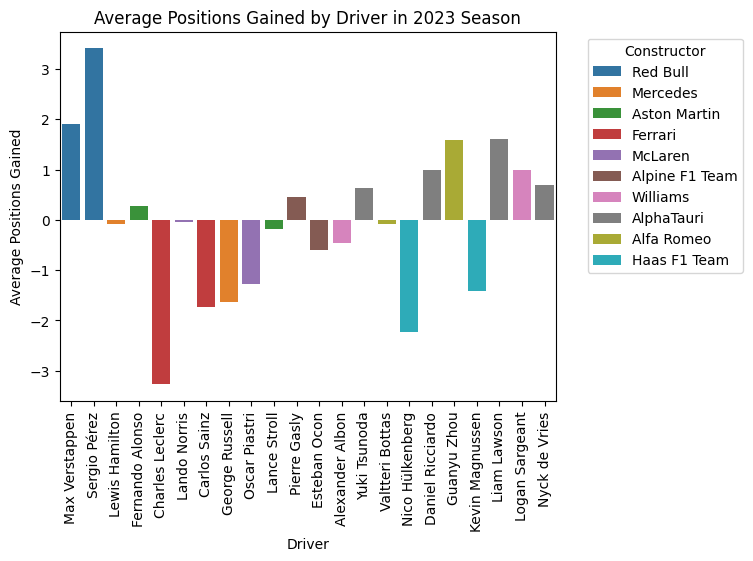

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot gained positions boxplot by driver 
sns.barplot(x="driver", y="positions_gained", data=build_season_summary(2023).get("drivers"), hue="constructor", dodge=False)  
plt.xticks(rotation=90)
plt.title("Average Positions Gained by Driver in 2023 Season")
plt.ylabel("Average Positions Gained")
plt.xlabel("Driver")
plt.legend(title="Constructor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show() 

In [47]:
import re

def is_season_query(q: str) -> Optional[int]:
    ql = q.lower()
    m = re.search(r"\b(20\d{2})\b", ql)
    year = int(m.group(1)) if m else None
    if ("saison" in ql or "season" in ql or "" in ql or "" in ql) and year:
        return year
    return None


In [48]:
# --- helper to be robust to SDK param name changes ---
def _complete_chat_robust(client, *, model, messages, temperature=0.2, max_tokens=600):
    try:
        # Newer SDKs
        return client.chat.complete(
            model=model,
            messages=messages,
            temperature=temperature,
            max_output_tokens=max_tokens,
            safe_prompt=False,
            random_seed=42,
        )
    except TypeError:
        # Older SDKs
        return client.chat.complete(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
        )

# --- build facts for season objects (drivers/constructors DataFrames) ---
def _season_facts_from_summary(season_summary: dict, top_n: int = 10) -> str:
    import pandas as pd

    year = season_summary.get("meta", {}).get("year")
    drivers = season_summary.get("drivers")
    constructors = season_summary.get("constructors")

    lines = []
    lines.append(f"Season: {year}")

    # Drivers top N with points/wins/podiums/eliminations
    if isinstance(drivers, pd.DataFrame) and not drivers.empty:
        d = drivers.sort_values("position").head(top_n).copy()
        # Some columns may be Int64/nullable; cast nicely for printing
        def _fmt_int(x): 
            try: 
                return str(int(x)) 
            except Exception: 
                return "0" if pd.isna(x) else str(x)
        dr_rows = []
        for _, r in d.iterrows():
            dr_rows.append(
                f"P{_fmt_int(r.get('position'))} {r.get('driver')} "
                f"({r.get('constructor')}) — {float(r.get('points', 0.0)):.1f} pts, "
                f"Wins:{_fmt_int(r.get('wins'))}, Podiums:{_fmt_int(r.get('podiums'))}, "
                f"Eliminations:{_fmt_int(r.get('eliminations'))}"
            )
        lines.append("Drivers (top {0}): {1}".format(top_n, " | ".join(dr_rows)))

    # Constructors top N
    if isinstance(constructors, pd.DataFrame) and not constructors.empty:
        c = constructors.sort_values("position").head(top_n).copy()
        cons_rows = [
            f"P{int(r['position'])} {r['constructor']} — {float(r['points']):.1f} pts, Wins:{int(r['wins'])}"
            for _, r in c.iterrows()
        ]
        lines.append("Constructors (top {0}): {1}".format(top_n, " | ".join(cons_rows)))

    return "\n".join(lines)

# --- your original GP facts builder (reuse summarize_plain) ---
# assumes you already have summarize_plain(summary) defined

# --- unified summarizer: GP or Season ---
def summarize_with_mistral(summary: dict, model: str = "mistral-small", query: str = ""):
    api_key = 'qihykHg51EDcgFERlOk1OLfAEiFJwp6K'  # (idéalement: via ENV)
    if not api_key:
        return summarize_plain(summary)

    try:
        from mistralai import Mistral
    except Exception:
        return summarize_plain(summary)

    # Detect season vs GP:
    # Season summary produced by build_season_summary has 'drivers' and 'constructors'
    is_season = ("drivers" in summary) and ("constructors" in summary)

    if is_season:
        facts = _season_facts_from_summary(summary, top_n=10)
        prompt = f"""
You are a concise Formula 1 analyst. Answer the following question: {query}
Write a compact season summary (6–10 sentences). USE ONLY the facts below. Do not speculate


Facts:
{facts}
""".strip()
        max_tok = 700
    else:
        # GP case: reuse your plain facts builder
        facts = summarize_plain(summary)
        prompt = f"""
You are a concise Formula 1 analyst. Answer the following question: {query}
Write a short Grand Prix summary (5–8 sentences). USE ONLY the facts below.
Do not speculate. End with one sentence about the circuit/context.

Facts:
{facts}
""".strip()
        max_tok = 500

    client = Mistral(api_key=api_key)
    resp = _complete_chat_robust(
        client,
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
        max_tokens=max_tok
    )

    # Return text robustly
    try:
        return resp.choices[0].message.content.strip()
    except Exception:
        try:
            return resp.choices[0].message.get("content", "").strip()
        except Exception:
            return summarize_plain(summary)


In [49]:
summary_gp = build_gp_summary("résumé grand prix de Singapore 2025")
print(summarize_with_mistral(summary_gp, query="résumé grand prix de Singapore 2025"))


At the 2025 Singapore Grand Prix, George Russell of Mercedes took the checkered flag first, followed by Max Verstappen of Red Bull Racing and Lando Norris of McLaren. Russell started the race in pole position and led every lap, earning his third victory of the season. Verstappen's second-place finish allowed him to extend his lead in the drivers' championship. Ferrari's Lewis Hamilton set the fastest lap of the race on lap 48 with a time of 93.808 seconds. The full classification of drivers saw Oscar Piastri in fourth place, Kimi Antonelli in fifth, and Charles Leclerc in sixth. Notably, Hamilton's eighth-place finish marked his lowest result of the season. The Marina Bay Street Circuit, with its challenging night race conditions, provided a thrilling backdrop to an exciting Grand Prix.


In [50]:
season = build_season_summary_text(2025)   # from the Ergast/Jolpi code you added

print(summarize_with_mistral(season, query="Who wins the 2025 drivers and constructors titles?"))


Based on the given facts, I cannot determine the winners of the 2


In [51]:
#number of token in season without using modeule 
def count_tokens(text: str) -> int:
    return len(text.split())
count_tokens(season["drivers"]) + count_tokens(season["constructors"])

325